# Food Vision - Milestone

In [1]:
# Importing TF and checking the version
import tensorflow as tf

print(tf.__version__)

2.10.1


In [2]:
# Getting helper functions
from DanielBourke_HelperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Using TensorFlow Datasets (TFDS)

In [3]:
# Getting TensorFlow Datasets
import tensorflow_datasets as tfds

In [4]:
# Listing all available datasets
datasets_list = tfds.list_builders()
#datasets_list

In [5]:
# Loading in the data
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

### Exploring TFDS Food101 dataset

In [6]:
# Features of Food101 dataset from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Taking one sample of train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Output info about our sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class: {label}
    Class name(str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class: 77
    Class name(str form): pork_chop
    


In [10]:
# Sample image structure
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [11]:
# Checking image's min/max values
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plotting TFDS sample image

(-0.5, 511.5, 511.5, -0.5)

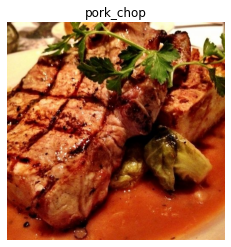

In [12]:
# Plotting an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

### Building a preprocessing function

In [13]:
# Making a function
def preprocess_img(image, label, img_shape=224):
    # Resize the image
    image = tf.image.resize(image, [img_shape, img_shape])
    # image = image / 255. # Optional rescaling
    # Convert image from uint8 to float32
    return tf.cast(image, tf.float32), label

In [14]:
# Preporcessing sample tensor
preprocessed_img = preprocess_img(image, label)[0]
print(f"""
Image before preprocessing: {image[:2]}
Image shape: {image.shape}
Image data type: {image.dtype}
Image after preprocessing: {preprocessed_img[:2]}
Image shape: {preprocessed_img.shape}
Image data type: {preprocessed_img.dtype}
""")


Image before preprocessing: [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]
Image shape: (512, 512, 3)
Image data type: <dtype: 'uint8'>
Image after preprocessing: [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]
Image shape: (224, 224, 3)
Image data type: <dtype: 'float32'>



### Batch and prepare datasets

In [15]:
# Map preprocessing function to training (and parallelise it)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle training data and turn into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
train_data, train_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Create modelling callbacks

In [17]:
# Getting callback function from the helper package
from DanielBourke_HelperFunctions import create_tensorboard_callback

In [18]:
# Creating ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
    verbose=0 # Don't print anything
)

### Setup mixed precision policy

In [21]:
# Activating mixed precision
from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16") # SETTING IT ON
mixed_precision.set_global_policy("float32") # SETTING IT OFF

In [23]:
# Checking global policy settings
mixed_precision.global_policy()

<Policy "float32">

### Building feature extraction model

In [26]:
# Creating a base model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = preprocessing.Rescaling(1/255.)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax")(x)
model = tf.keras.Model(inputs, outputs)

# Compiling the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [27]:
# Model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 activation_1 (Activation)   (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

In [28]:
# Checking data types at each layer level
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pooling2d_1 True float32 <Policy "float32">
dense_1 True float32 <Policy "float32">
activation_1 True float32 <Policy "float32">


In [29]:
# Fitting the model
history1 = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name="training_logs",
        experiment_name="efficientb0"
    ),
    model_checkpoint]
)

Saving TensorBoard log files to: training_logs/efficientb0/20230105-233508


Epoch 1/3
